In [4]:
# import pandas as pd
# import numpy as np
# import random
# import os
# from sklearn.preprocessing import StandardScaler
# from funcs.engineer_features_funcs import (
#     compute_mse_scores, compute_baseline_mse, 
#     compute_mse_with_added_feature, extract_tsfresh_features, 
#     evaluate_feature, compute_mse_with_dropped_feature
# )
# import optuna
# import logging
# import warnings
# from joblib import Parallel, delayed
# from xgboost import XGBRegressor
# from lightgbm import LGBMRegressor
# from sklearn.metrics import mean_squared_error
# import csv
# import matplotlib.pyplot as plt

# # Suppress Optuna logging
# optuna.logging.set_verbosity(optuna.logging.WARNING)
# # Suppress warnings
# warnings.filterwarnings("ignore", category=DeprecationWarning)
# warnings.filterwarnings("ignore", category=FutureWarning)
# warnings.filterwarnings("ignore", category=UserWarning)
# warnings.filterwarnings("ignore", category=RuntimeWarning)

# def main():
#     np.random.seed(42)
#     random.seed(42)
#     os.environ['PYTHONHASHSEED'] = str(42)

#     # Dummy values for testing/optimization
#     target = 'EXPGS'
#     feature_addition_rounds = 2
#     fc_params = 'MinimalFCParameters'

#     # Load data
#     X_train_transformed = pd.read_csv('data/processed/X_train_transformed.csv', index_col='Date', parse_dates=True)
#     X_test_transformed = pd.read_csv('data/processed/X_test_transformed.csv', index_col='Date', parse_dates=True)
#     y_train_transformed = pd.read_csv('data/processed/y_train_transformed.csv', index_col='Date', parse_dates=True)
#     y_test_transformed = pd.read_csv('data/processed/y_test_transformed.csv', index_col='Date', parse_dates=True)

#     # Combine X and y dataframes for feature engineering
#     train_combined = pd.concat([X_train_transformed, y_train_transformed], axis=1)
#     test_combined = pd.concat([X_test_transformed, y_test_transformed], axis=1)

#     # Ensure the column names are preserved
#     base_features = list(X_train_transformed.columns)

#     # Initial baseline MSE calculation
#     baseline_mse_scores, aggregated_baseline_mse, best_params = compute_mse_scores(
#         X_train_transformed, X_test_transformed, y_train_transformed, y_test_transformed, base_features
#     )

#     print(f"Baseline MSE Scores:")
#     print(baseline_mse_scores)
#     print(f"Aggregated Baseline MSE Score: {aggregated_baseline_mse}\n")

#     initial_baseline_mse = aggregated_baseline_mse

#     initial_mse_xgboost = baseline_mse_scores['XGBoost']
#     initial_mse_lightgbm = baseline_mse_scores['LightGBM']

#     # Save best params as dictionaries
#     xgboost_params = best_params['XGBoost']
#     lightgbm_params = best_params['LightGBM']

#     # Save to a Python file
#     with open('best_params.py', 'w') as f:
#         f.write(f"xgboost_params = {xgboost_params}\n")
#         f.write(f"lightgbm_params = {lightgbm_params}\n")

#     print("Best parameters saved to best_params.py.")

#     # Function to compute MSE scores after dropping a feature
#     def compute_mse_with_dropped_feature(X_train, X_test, y_train, y_test, base_features, drop_feature):
#         X_train = X_train[[f for f in base_features if f != drop_feature]].dropna().values
#         X_test = X_test[[f for f in base_features if f != drop_feature]].dropna().values
#         y_train = y_train.dropna().values.ravel()
#         y_test = y_test.dropna().values.ravel()

#         scaler = StandardScaler()
#         X_train = scaler.fit_transform(X_train)
#         X_test = scaler.transform(X_test)

#         mse_scores = {'XGBoost': [], 'LightGBM': []}

#         models = {
#             'XGBoost': XGBRegressor(**xgboost_params, verbosity=0),
#             'LightGBM': LGBMRegressor(**lightgbm_params, verbosity=-1)
#         }

#         for model_name, model in models.items():
#             model.fit(X_train, y_train)
#             y_pred = model.predict(X_test)
#             mse_scores[model_name].append(mean_squared_error(y_test, y_pred))

#         mse_scores = {model: np.mean(scores) for model, scores in mse_scores.items()}
#         aggregated_mse = sum(mse_scores.values())

#         return mse_scores, aggregated_mse

#     # Function to drop features
#     def drop_features(train_combined, target, base_features, aggregated_baseline_mse, threshold):
#         aggregated_mse_scores_dropped = []
#         for feature in base_features:
#             mse_scores, aggregated_mse = compute_mse_with_dropped_feature(X_train_transformed, X_test_transformed, y_train_transformed, y_test_transformed, base_features, feature)
#             improvement = aggregated_baseline_mse - aggregated_mse
#             improvement_status = "improved" if improvement > threshold else "worsened"
#             aggregated_mse_scores_dropped.append((feature, aggregated_mse, improvement, improvement_status, mse_scores))

#         # Sort and drop the least impactful features if they result in improvement
#         aggregated_mse_scores_dropped.sort(key=lambda x: x[1])
#         features_to_drop = [f for f in aggregated_mse_scores_dropped if f[2] > threshold]

#         if not features_to_drop:
#             print("No features were dropped as they did not improve the model.")
#         else:
#             for feature, _, improvement, _, _ in features_to_drop:
#                 base_features.remove(feature)
#                 print(f"Feature dropped: {feature}, Improvement: {improvement}")

#         print("Feature Dropping Completed.")

#     # Loop through different threshold values
#     results = []

#     for threshold in np.linspace(0.0001, 0.01, 100):
#         # Make a copy of base_features to ensure each run starts with the same features
#         base_features_copy = base_features.copy()

#         # Perform feature dropping
#         drop_features(train_combined, target, base_features_copy, aggregated_baseline_mse, threshold)

#         # Final baseline MSE calculation
#         final_mse_scores, aggregated_final_mse, _ = compute_mse_scores(
#             X_train_transformed, X_test_transformed, y_train_transformed, y_test_transformed, base_features_copy
#         )
#         # Store final MSE scores for each model
#         final_mse_xgboost = final_mse_scores['XGBoost']
#         final_mse_lightgbm = final_mse_scores['LightGBM']

#         # Calculate improvements
#         improvement_xgboost = initial_mse_xgboost - final_mse_xgboost
#         improvement_lightgbm = initial_mse_lightgbm - final_mse_lightgbm

#         # Save results
#         results.append({
#             'threshold': threshold,
#             'initial_mse_xgboost': initial_mse_xgboost,
#             'final_mse_xgboost': final_mse_xgboost,
#             'improvement_xgboost': improvement_xgboost,
#             'initial_mse_lightgbm': initial_mse_lightgbm,
#             'final_mse_lightgbm': final_mse_lightgbm,
#             'improvement_lightgbm': improvement_lightgbm,
#             'aggregated_initial_mse': initial_baseline_mse,
#             'aggregated_final_mse': aggregated_final_mse
#         })

#         print(f"Threshold: {threshold}, XGBoost Improvement: {improvement_xgboost}, LightGBM Improvement: {improvement_lightgbm}")

#     # Save results to a CSV file
#     results_df = pd.DataFrame(results)
#     results_df.to_csv('threshold_optimization_results.csv', index=False)
#     print("Results saved to threshold_optimization_results.csv.")

# # Run the main function
# main()


Baseline MSE Scores:
{'XGBoost': 0.0005040139001331773, 'LightGBM': 0.0006031543432714184}
Aggregated Baseline MSE Score: 0.0011071682434045957

Best parameters saved to best_params.py.
Feature dropped: PCE, Improvement: 0.0003247872644615247
Feature dropped: CUSR0000SAH1, Improvement: 0.00029823411330279204
Feature dropped: PAYEMS, Improvement: 0.0002915682490472666
Feature dropped: DGS10, Improvement: 0.00028914367208745335
Feature dropped: FEDFUNDS, Improvement: 0.00028499603101952856
Feature dropped: PRFI, Improvement: 0.00027519698841089644
Feature dropped: DSPI, Improvement: 0.000268387000372421
Feature dropped: HOUST, Improvement: 0.0002491024593787426
Feature dropped: INDPRO, Improvement: 0.0002471650893594501
Feature dropped: DGS2, Improvement: 0.0002451120650114123
Feature dropped: CPILFESL, Improvement: 0.00024337036679739792
Feature dropped: CPIAUCSL, Improvement: 0.00023481486843439446
Feature dropped: AAA, Improvement: 0.0002331262580689468
Feature dropped: PCEPILFE, Impr

[W 2024-07-28 16:44:56,224] Trial 45 failed with parameters: {'num_leaves': 259, 'learning_rate': 0.03605365141751504, 'n_estimators': 212, 'max_depth': 17, 'min_child_samples': 16, 'subsample': 0.8501562541302907, 'colsample_bytree': 0.5207820940954125, 'reg_alpha': 0.0870245430548461, 'reg_lambda': 1.6177849279399557} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "c:\Users\nabounaser\AppData\Local\miniconda3\envs\autogluon_env\lib\site-packages\optuna\study\_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "c:\Users\nabounaser\OneDrive - Ejada Systems\EJADA\MacroEconomicAPI\funcs\engineer_features_funcs.py", line 73, in <lambda>
    study.optimize(lambda trial: objective(trial, model_name), n_trials=50)
  File "c:\Users\nabounaser\OneDrive - Ejada Systems\EJADA\MacroEconomicAPI\funcs\engineer_features_funcs.py", line 65, in objective
    model.fit(X_train_scaled, y_train)
  File "c:\Users\nabounaser\AppDat

KeyboardInterrupt: 

In [15]:
import pandas as pd
import numpy as np
import random
import os
from sklearn.preprocessing import StandardScaler
from funcs.engineer_features_funcs import (
    compute_mse_scores, compute_baseline_mse, 
    compute_mse_with_added_feature, extract_tsfresh_features, 
    evaluate_feature, compute_mse_with_dropped_feature
)
import optuna
import logging
import warnings
from joblib import Parallel, delayed
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
import csv
import matplotlib.pyplot as plt
from funcs.api_funcs import get_target_arg, get_feature_dropping_threshold_arg, get_feature_addition_rounds_arg, get_tsfresh_fc_params_arg

# Suppress Optuna logging
optuna.logging.set_verbosity(optuna.logging.WARNING)
# Suppress warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

def main():
    np.random.seed(42)
    random.seed(42)
    os.environ['PYTHONHASHSEED'] = str(42)

    # Dummy values for testing/optimization
    target = 'EXPGS'
    feature_addition_rounds = 2
    fc_params = 'MinimalFCParameters'

    # Load data
    X_train_transformed = pd.read_csv('data/processed/X_train_transformed.csv', index_col='Date', parse_dates=True)
    X_test_transformed = pd.read_csv('data/processed/X_test_transformed.csv', index_col='Date', parse_dates=True)
    y_train_transformed = pd.read_csv('data/processed/y_train_transformed.csv', index_col='Date', parse_dates=True)
    y_test_transformed = pd.read_csv('data/processed/y_test_transformed.csv', index_col='Date', parse_dates=True)

    # Combine X and y dataframes for feature engineering
    train_combined = pd.concat([X_train_transformed, y_train_transformed], axis=1)
    test_combined = pd.concat([X_test_transformed, y_test_transformed], axis=1)

    # Ensure the column names are preserved
    base_features = list(X_train_transformed.columns)

    # Initial baseline MSE calculation
    baseline_mse_scores, aggregated_baseline_mse, best_params = compute_mse_scores(
        X_train_transformed, X_test_transformed, y_train_transformed, y_test_transformed, base_features
    )

    print(f"Baseline MSE Scores:")
    print(baseline_mse_scores)
    print(f"Aggregated Baseline MSE Score: {aggregated_baseline_mse}\n")

    initial_baseline_mse = aggregated_baseline_mse

    initial_mse_xgboost = baseline_mse_scores['XGBoost']
    initial_mse_lightgbm = baseline_mse_scores['LightGBM']

    # Save best params as dictionaries
    xgboost_params = best_params['XGBoost']
    lightgbm_params = best_params['LightGBM']

    # Save to a Python file
    with open('best_params.py', 'w') as f:
        f.write(f"xgboost_params = {xgboost_params}\n")
        f.write(f"lightgbm_params = {lightgbm_params}\n")

    print("Best parameters saved to best_params.py.")

    # Function to compute MSE scores after dropping a feature
    def compute_mse_with_dropped_feature(X_train, X_test, y_train, y_test, base_features, drop_feature):
        X_train = X_train[[f for f in base_features if f != drop_feature]].dropna().values
        X_test = X_test[[f for f in base_features if f != drop_feature]].dropna().values
        y_train = y_train.dropna().values.ravel()
        y_test = y_test.dropna().values.ravel()

        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        mse_scores = {'XGBoost': [], 'LightGBM': []}

        models = {
            'XGBoost': XGBRegressor(**xgboost_params, verbosity=0),
            'LightGBM': LGBMRegressor(**lightgbm_params, verbosity=-1)
        }

        for model_name, model in models.items():
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            mse_scores[model_name].append(mean_squared_error(y_test, y_pred))

        mse_scores = {model: np.mean(scores) for model, scores in mse_scores.items()}
        aggregated_mse = sum(mse_scores.values())

        return mse_scores, aggregated_mse

    # Function to drop features
    def drop_features(train_combined, target, base_features, aggregated_baseline_mse, threshold):
        aggregated_mse_scores_dropped = []
        for feature in base_features:
            mse_scores, aggregated_mse = compute_mse_with_dropped_feature(X_train_transformed, X_test_transformed, y_train_transformed, y_test_transformed, base_features, feature)
            improvement = aggregated_baseline_mse - aggregated_mse
            improvement_status = "improved" if improvement > threshold else "worsened"
            aggregated_mse_scores_dropped.append((feature, aggregated_mse, improvement, improvement_status, mse_scores))

        # Sort and drop the least impactful features if they result in improvement
        aggregated_mse_scores_dropped.sort(key=lambda x: x[1])
        features_to_drop = [f for f in aggregated_mse_scores_dropped if f[2] > threshold]

        if not features_to_drop:
            print("No features were dropped as they did not improve the model.")
        else:
            for feature, _, improvement, _, _ in features_to_drop:
                base_features.remove(feature)
                print(f"Feature dropped: {feature}, Improvement: {improvement}")

        print("Feature Dropping Completed.")

    # Perform feature addition once
    for _ in range(feature_addition_rounds):
        added_feature = f'added_feature_{_}'  # Dummy feature name
        X_train_transformed[added_feature] = np.random.rand(X_train_transformed.shape[0])
        X_test_transformed[added_feature] = np.random.rand(X_test_transformed.shape[0])
        base_features.append(added_feature)

    # Loop through different relative threshold values for feature dropping
    results = []

    for relative_threshold in np.linspace(0.0001, 0.01, 100):
        # Calculate the actual threshold based on the relative threshold and aggregated baseline MSE
        threshold = relative_threshold * aggregated_baseline_mse

        # Make a copy of base_features to ensure each run starts with the same features
        base_features_copy = base_features.copy()

        # Perform feature dropping
        drop_features(train_combined, target, base_features_copy, aggregated_baseline_mse, threshold)

        # Final baseline MSE calculation
        final_mse_scores, aggregated_final_mse, _ = compute_mse_scores(
            X_train_transformed, X_test_transformed, y_train_transformed, y_test_transformed, base_features_copy
        )
        # Store final MSE scores for each model
        final_mse_xgboost = final_mse_scores['XGBoost']
        final_mse_lightgbm = final_mse_scores['LightGBM']

        # Calculate improvements
        improvement_xgboost = initial_mse_xgboost - final_mse_xgboost
        improvement_lightgbm = initial_mse_lightgbm - final_mse_lightgbm

        # Save results
        results.append({
            'relative_threshold': relative_threshold,
            'threshold': threshold,
            'initial_mse_xgboost': initial_mse_xgboost,
            'final_mse_xgboost': final_mse_xgboost,
            'improvement_xgboost': improvement_xgboost,
            'initial_mse_lightgbm': initial_mse_lightgbm,
            'final_mse_lightgbm': final_mse_lightgbm,
            'improvement_lightgbm': improvement_lightgbm,
            'aggregated_initial_mse': initial_baseline_mse,
            'aggregated_final_mse': aggregated_final_mse
        })

        print(f"Relative Threshold: {relative_threshold}, Threshold: {threshold}, XGBoost Improvement: {improvement_xgboost}, LightGBM Improvement: {improvement_lightgbm}")

    # Save results to a CSV file
    results_df = pd.DataFrame(results)
    results_df.to_csv('threshold_optimization_results.csv', index=False)
    print("Results saved to threshold_optimization_results.csv.")

# Run the main function
if __name__ == '__main__':
    main()


Baseline MSE Scores:
{'XGBoost': 0.0005121471232352867, 'LightGBM': 0.0005885437312524484}
Aggregated Baseline MSE Score: 0.001100690854487735

Best parameters saved to best_params.py.
Feature dropped: CUSR0000SAH1, Improvement: 0.0004636324321482338
Feature dropped: AAA, Improvement: 0.0004018438204659749
Feature dropped: CUMFNS, Improvement: 0.0003962187644865829
Feature dropped: UNRATE, Improvement: 0.00039195882596258736
Feature dropped: INDPRO, Improvement: 0.00038763796625884933
Feature dropped: PRFI, Improvement: 0.000380896065197759
Feature dropped: CPIAUCSL, Improvement: 0.00037686448084366694
Feature dropped: PCE, Improvement: 0.00037400069474090216
Feature dropped: added_feature_1, Improvement: 0.00037290284430665794
Feature dropped: DSPI, Improvement: 0.00036369442070510846
Feature dropped: FEDFUNDS, Improvement: 0.00036133760353232263
Feature dropped: CPILFESL, Improvement: 0.00035619768373361393
Feature dropped: HOUST, Improvement: 0.0003556823452309835
Feature dropped: G

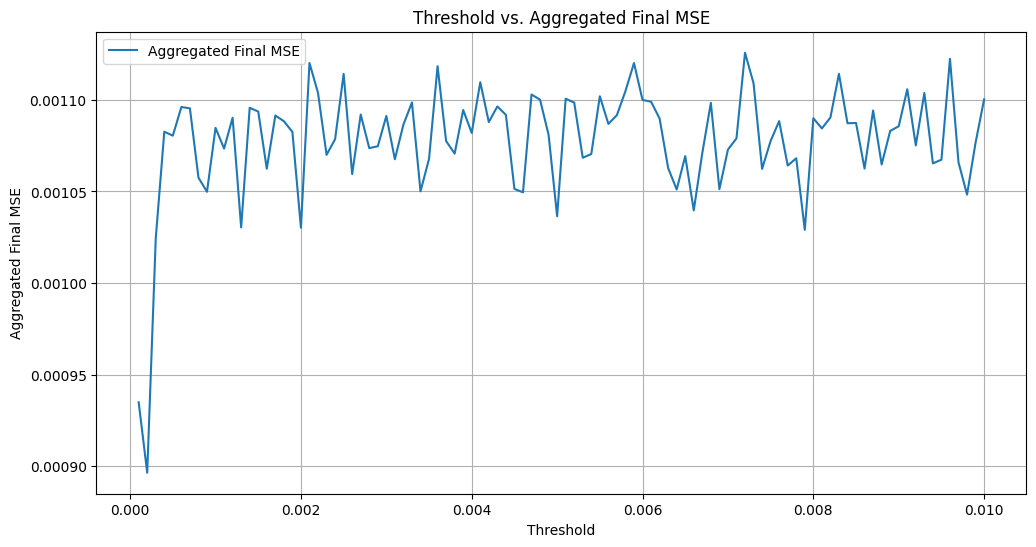

Best Threshold: 0.0002
Initial MSE XGBoost: 0.0004904671093473, Final MSE XGBoost: 0.0004315820776654, Improvement: 5.888503168195004e-05
Initial MSE LightGBM: 0.000588762083599, Final MSE LightGBM: 0.000464792149033, Improvement: 0.000123969934566
Aggregated Initial MSE: 0.0010792291929464, Aggregated Final MSE: 0.0008963742266984


In [9]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the results from the CSV file
results_df = pd.read_csv('threshold_optimization_results.csv')

# Find the best threshold value based on the lowest aggregated final MSE
best_threshold = results_df.loc[results_df['aggregated_final_mse'].idxmin()]

# Plot the threshold vs. improvement in MSE
plt.figure(figsize=(12, 6))
plt.plot(results_df['threshold'], results_df['aggregated_final_mse'], label='Aggregated Final MSE')
plt.xlabel('Threshold')
plt.ylabel('Aggregated Final MSE')
plt.title('Threshold vs. Aggregated Final MSE')
plt.legend()
plt.grid(True)
plt.show()

print(f"Best Threshold: {best_threshold['threshold']}")
print(f"Initial MSE XGBoost: {best_threshold['initial_mse_xgboost']}, Final MSE XGBoost: {best_threshold['final_mse_xgboost']}, Improvement: {best_threshold['improvement_xgboost']}")
print(f"Initial MSE LightGBM: {best_threshold['initial_mse_lightgbm']}, Final MSE LightGBM: {best_threshold['final_mse_lightgbm']}, Improvement: {best_threshold['improvement_lightgbm']}")
print(f"Aggregated Initial MSE: {best_threshold['aggregated_initial_mse']}, Aggregated Final MSE: {best_threshold['aggregated_final_mse']}")


In [ ]:
# SECOND CASE: (2)
import pandas as pd
import matplotlib.pyplot as plt

# Load the results from the CSV file
results_df = pd.read_csv('threshold_optimization_results.csv')

# Find the best threshold value based on the lowest aggregated final MSE
best_threshold = results_df.loc[results_df['aggregated_final_mse'].idxmin()]

# Plot the threshold vs. improvement in MSE
plt.figure(figsize=(12, 6))
plt.plot(results_df['threshold'], results_df['aggregated_final_mse'], label='Aggregated Final MSE')
plt.xlabel('Threshold')
plt.ylabel('Aggregated Final MSE')
plt.title('Threshold vs. Aggregated Final MSE')
plt.legend()
plt.grid(True)
plt.show()

print(f"Best Threshold: {best_threshold['threshold']}")
print(f"Initial MSE XGBoost: {best_threshold['initial_mse_xgboost']}, Final MSE XGBoost: {best_threshold['final_mse_xgboost']}, Improvement: {best_threshold['improvement_xgboost']}")
print(f"Initial MSE LightGBM: {best_threshold['initial_mse_lightgbm']}, Final MSE LightGBM: {best_threshold['final_mse_lightgbm']}, Improvement: {best_threshold['improvement_lightgbm']}")
print(f"Aggregated Initial MSE: {best_threshold['aggregated_initial_mse']}, Aggregated Final MSE: {best_threshold['aggregated_final_mse']}")


In [10]:
# Find the 3 lowest MSE scores
lowest_mse_scores = results_df.nsmallest(3, 'aggregated_final_mse')
print(lowest_mse_scores)

   threshold  initial_mse_xgboost  final_mse_xgboost  improvement_xgboost  \
1     0.0002              0.00049           0.000432             0.000059   
0     0.0001              0.00049           0.000471             0.000019   
2     0.0003              0.00049           0.000483             0.000007   

   initial_mse_lightgbm  final_mse_lightgbm  improvement_lightgbm  \
1              0.000589            0.000465              0.000124   
0              0.000589            0.000463              0.000125   
2              0.000589            0.000541              0.000048   

   aggregated_initial_mse  aggregated_final_mse  
1                0.001079              0.000896  
0                0.001079              0.000935  
2                0.001079              0.001024  
